In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from clean import clean_data
import random
import optuna
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

In [2]:
seed = 777

In [3]:
file_path = "../data/TBI PUD 10-08-2013.csv"
_, train_df, test_df = clean_data(file_path)

# Make two models with CV

## Decision Tree

In [22]:
# Make data for Decision Tree
# Fill na with 99999 to make the tree moddel recognize nan
train_df_tree = train_df.dropna(subset=["PosIntFinal"])
train_df_tree = train_df_tree.fillna(99999)

test_df_tree = test_df.dropna(subset=["PosIntFinal"])
test_df_tree = test_df_tree.fillna(99999)

In [5]:
# CV
def evalation_metric(y_true, y_pred):
    # Smae as Kuppermann (2009)
    cm = confusion_matrix(y_true, y_pred)
    fp = cm[0, 1] / (cm[0, 1] + cm[0, 0])
    fn = cm[1, 0] / (cm[1, 0] + cm[1, 1])

    return 500 * fn + fp


def objective(trial):
    """
    Using Optuna to find the best hyperparameter for Decision Tree
    """
    # candidates of hyperparameter
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    splitter = trial.suggest_categorical("splitter", ["best", "random"])
    max_depth = trial.suggest_int("max_depth", 1, 8)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 20)
    max_features = trial.suggest_categorical("max_features", [None, "sqrt", "log2"])
    max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 2, 20)
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])

    clf = DecisionTreeClassifier(
        criterion=criterion,
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        max_leaf_nodes=max_leaf_nodes,
        class_weight=class_weight,
    )

    kf = StratifiedKFold(
        n_splits=10, shuffle=True, random_state=777
    )  # Smae as Kuppermann (2009)
    X = train_df_tree.drop(columns=["PosIntFinal"])
    y = train_df_tree["PosIntFinal"]

    # Evaluate each fold
    scores = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = evalation_metric(y_test, y_pred)
        scores.append(score)

    return np.mean(scores)  # Return the mean of CV scores


sampler = optuna.samplers.TPESampler(seed=seed)
study = optuna.create_study(sampler=sampler, direction="minimize")
study.optimize(objective, n_trials=50)

trial = study.best_trial

[I 2025-02-20 18:56:40,903] A new study created in memory with name: no-name-a46b2d41-e377-4937-b26d-e8496a3e137b
[I 2025-02-20 18:56:41,368] Trial 0 finished with value: 100.52109875331442 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 7, 'min_samples_split': 19, 'min_samples_leaf': 15, 'max_features': None, 'max_leaf_nodes': 3, 'class_weight': 'balanced'}. Best is trial 0 with value: 100.52109875331442.
[I 2025-02-20 18:56:41,683] Trial 1 finished with value: 108.41074210820054 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': 'log2', 'max_leaf_nodes': 5, 'class_weight': 'balanced'}. Best is trial 0 with value: 100.52109875331442.
[I 2025-02-20 18:56:42,068] Trial 2 finished with value: 360.7036261994466 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 11, 'min_samples_leaf': 11, 'max_features': None, 'max_leaf_nodes'

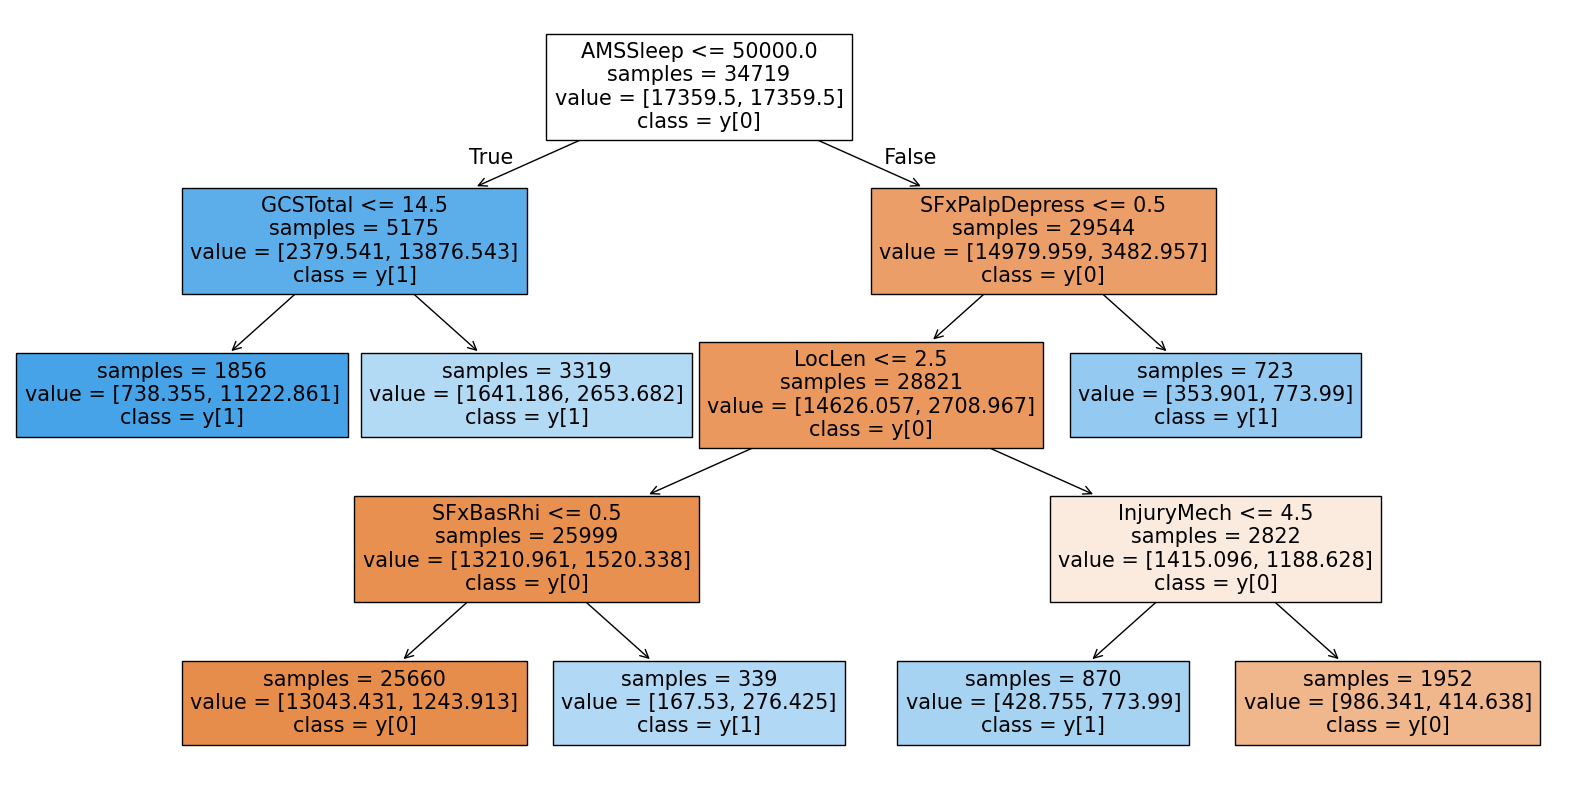

In [6]:
best_clf = DecisionTreeClassifier(
    criterion=trial.params["criterion"],
    splitter=trial.params["splitter"],
    max_depth=trial.params["max_depth"],
    min_samples_split=trial.params["min_samples_split"],
    min_samples_leaf=trial.params["min_samples_leaf"],
    max_features=trial.params["max_features"],
    max_leaf_nodes=trial.params["max_leaf_nodes"],
    class_weight=trial.params["class_weight"],
)

best_clf.fit(train_df_tree.drop(columns=["PosIntFinal"]), train_df_tree["PosIntFinal"])

plt.figure(figsize=(20, 10))
plot_tree(
    best_clf,
    feature_names=train_df_tree.drop(columns=["PosIntFinal"]).columns,
    class_names=True,
    impurity=False,
    filled=True,
)
plt.savefig("../figs/Decision_Tree.pdf", format="pdf")
plt.show()

In [7]:
# Confusion Matrix(Train)
y_pred = best_clf.predict(train_df_tree.drop(columns=["PosIntFinal"]))
confusion_matrix(train_df_tree["PosIntFinal"], y_pred)

array([[27552,  6539],
       [   60,   568]], dtype=int64)

In [8]:
# Confusion Matrix(Test)
y_pred = best_clf.predict(test_df_tree.drop(columns=["PosIntFinal"]))
confusion_matrix(test_df_tree["PosIntFinal"], y_pred)

array([[6867, 1681],
       [  14,  118]], dtype=int64)

# Logistic Regression

In [33]:
train_df_LR = train_df.dropna(subset=["PosIntFinal", "AgeInMonth", "GCSTotal"])
test_df_LR = test_df.dropna(subset=["PosIntFinal", "AgeInMonth", "GCSTotal"])


num_cols = ["AgeInMonth", "GCSTotal"]
cat_cols = [col for col in train_df_LR.columns if col not in num_cols + ["PosIntFinal"]]

# Standardlize
scaler = StandardScaler()
train_df_LR[num_cols] = scaler.fit_transform(train_df_LR[num_cols])
test_df_LR[num_cols] = scaler.transform(test_df_LR[num_cols])

# one-hot
test_df_LR[cat_cols] = test_df_LR[cat_cols].fillna(99999)
train_df_LR[cat_cols] = train_df_LR[cat_cols].fillna(99999)
train_df_LR = pd.get_dummies(train_df_LR, columns=cat_cols)
test_df_LR = pd.get_dummies(test_df_LR, columns=cat_cols)

In [11]:
# CV
def objective(trial):
    """
    Using Optuna to find the best hyperparameter for Decision Tree
    """
    # candidates of hyperparameter
    C = trial.suggest_loguniform("C", 1e-3, 1e3)
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])

    model_params = {
        "C": C,
        "penalty": "l1",
        "solver": "saga",
        "max_iter": 1000,
        "class_weight": class_weight,
    }
    model = LogisticRegression(**model_params)

    kf = StratifiedKFold(
        n_splits=3, shuffle=True, random_state=seed
    )  # Considering computation cost, I used 3-fold CV.
    X = train_df_LR.drop(columns=["PosIntFinal"])
    y = train_df_LR["PosIntFinal"]

    # Evaluate each fold
    scores = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = evalation_metric(y_test, y_pred)
        scores.append(score)

    return np.mean(scores)  # Return the mean of CV scores


sampler = optuna.samplers.TPESampler(seed=seed)
study = optuna.create_study(sampler=sampler, direction="minimize")
study.optimize(
    objective, n_trials=10
)  # Considering computation cost and num of hyperparameters, I used 10 trials.

trial = study.best_trial

[I 2025-02-20 19:08:39,543] A new study created in memory with name: no-name-77e1af84-f29f-4168-ad66-fb0e5efbe5c4
C:\Users\jyuny\AppData\Local\Temp\ipykernel_14156\1233162193.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-3, 1e3)
[I 2025-02-20 19:08:43,351] Trial 0 finished with value: 372.60763414375305 and parameters: {'C': 0.0082410473493473, 'class_weight': None}. Best is trial 0 with value: 372.60763414375305.
C:\Users\jyuny\AppData\Local\Temp\ipykernel_14156\1233162193.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-3, 1e3)
c:\Users\jyuny\anaconda3\envs\stat214\Lib\site-packages\skl

In [12]:
best_model_params = {
    "C": trial.params["C"],
    "penalty": "l1",
    "solver": "saga",
    "max_iter": 1000,
    "class_weight": trial.params["class_weight"],
}
best_LR = LogisticRegression(**best_model_params)
best_LR.fit(train_df_LR.drop(columns=["PosIntFinal"]), train_df_LR["PosIntFinal"])

c:\Users\jyuny\anaconda3\envs\stat214\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=0.574330724044111, class_weight='balanced', max_iter=1000,
                   penalty='l1', solver='saga')

In [13]:
best_LR.coef_

array([[-2.84943099e+00, -1.45399640e-01,  1.57058951e+00,
         8.26347900e-02,  8.76335239e-01, -4.31959189e-01,
         2.13360204e+00, -2.20221088e-01, -1.06514301e-01,
        -2.37694077e-01, -6.14484254e-02, -2.04630088e-01,
        -2.20753345e+00,  1.13696492e+00,  9.46645425e-02,
        -2.03582712e+00, -9.90620722e-01,  1.98380740e+00,
         6.02320472e-01, -6.40975407e-01, -5.24413290e-03,
         5.88544459e-01, -2.45803014e+00, -2.10798928e-01,
        -5.36218414e-01,  1.43422251e-01,  1.95083669e+00,
         1.33512649e+00, -1.87192955e-01, -1.03314560e+00,
        -7.66508990e-01,  2.70405877e+00,  3.89298739e+00,
         5.11581151e-01,  4.62094350e-01, -1.03314560e+00,
        -3.73200250e-01,  2.03265649e-01,  1.10806470e+00,
         6.17481044e+00, -5.67097304e-01,  4.62094350e-01,
        -1.61536003e-01, -1.01367792e+00,  1.80637118e+00,
         1.15360298e-01, -1.43536830e+00,  2.14833171e-01,
        -2.77931188e-01, -1.96713350e-01,  8.43844113e-0

In [14]:
# Confusion Matrix(Train)
y_pred = best_LR.predict(train_df_LR.drop(columns=["PosIntFinal"]))
confusion_matrix(train_df_LR["PosIntFinal"], y_pred)

array([[31562,  2529],
       [   92,   536]], dtype=int64)

In [34]:
# Confusion Matrix(Test)
missing_cols = set(train_df_LR.columns) - set(test_df_LR.columns)
for col in missing_cols:
    test_df_LR[col] = 0  # If no data in test data, assume 0
test_df_LR_fixed = test_df_LR[train_df_LR.drop(columns=["PosIntFinal"]).columns]

y_pred = best_LR.predict(test_df_LR_fixed)
confusion_matrix(test_df_LR["PosIntFinal"], y_pred)

array([[7899,  649],
       [  27,  105]], dtype=int64)